In [38]:
import argparse
# from collections import OrderedDict
import copy
import cupy as cp
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.size" : 18,
    "text.usetex": True,
    "font.family": "Helvetica",
})
%matplotlib inline
# from multiprocessing import Process,Manager
import numpy as np
import os
import pandas as pd
import pickle
from scipy import sparse
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tensorboardX import SummaryWriter
from tqdm import tqdm

from models import EVCF
import data
from mymetric import calc_metric

# Set Configs

In [39]:
##  Set the random seed manually for reproductibility.
seed = 1
torch.manual_seed(seed)

In [40]:
device= torch.device("cuda")
# device = torch.device("cpu")

In [41]:
ALGO_NAME="EVCF"
DATASET_NAME="ml-20m"

In [42]:
# Load Data
loader = data.DataLoader('dataset/{}'.format(DATASET_NAME))

n_items = loader.load_n_items()
train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')
test_data_tr, test_data_te = loader.load_data('test')

N = train_data.shape[0]
idxlist = list(range(N))

print("# of items:{}".format(n_items))

# of items:19907


In [43]:
# Build the model
args = {
    'input_size': n_items,
    'hidden_size': 600,
    'z1_size': 100, # latent_size
    'z2_size': 100,
    'num_layers': 1,
    'gated': False,
    'number_components': 1000,
    # 'pseudoinputs_mean' : 0.05,
    # 'pseudoinputs_std' : 0.01,
    # 'pseudoinputs_mean' : 0.0,
    # 'pseudoinputs_std' : 1,
    'device': device,
}
model = EVCF(args).to(device)

print(f"Model Structure:{model}\n")
# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.00)
# criterion = models.loss_function

Model Structure:EVCF(
  (q_z2_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): NonLinear(
      (activation): Tanh()
      (linear): Linear(in_features=19907, out_features=600, bias=True)
    )
  )
  (q_z2_mean): Linear(in_features=600, out_features=100, bias=True)
  (q_z2_logvar): NonLinear(
    (activation): Hardtanh(min_val=-12.0, max_val=4.0)
    (linear): Linear(in_features=600, out_features=100, bias=True)
  )
  (q_z1_layers_x): Sequential(
    (0): Dropout(p=0.5, inplace=False)
  )
  (q_z1_layers_z2): Sequential()
  (q_z1_layers_joint): Sequential(
    (0): NonLinear(
      (activation): Tanh()
      (linear): Linear(in_features=20007, out_features=600, bias=True)
    )
  )
  (q_z1_mean): Linear(in_features=600, out_features=100, bias=True)
  (q_z1_logvar): NonLinear(
    (activation): Hardtanh(min_val=-12.0, max_val=4.0)
    (linear): Linear(in_features=600, out_features=100, bias=True)
  )
  (p_z1_layers): Sequential(
    (0): NonLinear(
      (activation):

In [44]:
# TensorboardX Writer
writer= SummaryWriter()

In [45]:
# Train

In [46]:
BATCH_SIZE = 500
TOTAL_ANNEAL_STEPS = 200000
ANNEAL_CAP = 1
LOG_INTERVAL = 100
# EPOCHS = 100
EPOCHS = 200
SAVE_DIR = 'saved_model/{}/{}'.format(ALGO_NAME, DATASET_NAME)
SAVE_PATH = '{}/model_ep{}_cap{}_step{}.pt'.format(SAVE_DIR,EPOCHS,ANNEAL_CAP,TOTAL_ANNEAL_STEPS)

os.makedirs(SAVE_DIR, exist_ok=True)

In [47]:
def sparse2torch_sparse(data):
    """
    Convert scipy sparse matrix to torch sparse tensor with L2 Normalization
    This is much faster than naive use of torch.FloatTensor(data.toarray())
    https://discuss.pytorch.org/t/sparse-tensor-use-cases/22047/2
    """
    samples = data.shape[0]
    features = data.shape[1]
    coo_data = data.tocoo()
    indices = torch.LongTensor([coo_data.row, coo_data.col])
    row_norms_inv = 1 / np.sqrt(data.sum(1))
    row2val = {i : row_norms_inv[i].item() for i in range(samples)}
    values = np.array([row2val[r] for r in coo_data.row])
    t = torch.sparse.FloatTensor(indices, torch.from_numpy(values).float(), [samples, features])
    return t

In [48]:
def naive_sparse2tensor(data):
    return torch.FloatTensor(data.toarray())

In [49]:
def train(model, optimizer, train_data):
    # Turn on training mode
    model.train()
    train_loss = 0.0
    start_time = time.time()
    global update_count

    np.random.shuffle(idxlist)
    
    for batch_idx, start_idx in enumerate(range(0, N, BATCH_SIZE)):
        end_idx = min(start_idx + BATCH_SIZE, N)
        data = train_data[idxlist[start_idx:end_idx]]
        data = naive_sparse2tensor(data).to(device)

        if TOTAL_ANNEAL_STEPS > 0:
            anneal = min(ANNEAL_CAP, 
                            1. * update_count / TOTAL_ANNEAL_STEPS)
        else:
            anneal = ANNEAL_CAP

        optimizer.zero_grad()
        
        # x,_,_,_,_= model(data)
        loss,_,_,_ = model.calculate_loss(data, beta=anneal,average=True)
        loss.backward()
        
        train_loss += loss.item()
        
        optimizer.step()

        update_count += 1

        if batch_idx % LOG_INTERVAL == 0 and batch_idx > 0:
            elapsed = time.time() - start_time
            # print('| epoch {:3d} | {:4d}/{:4d} batches | ms/batch {:4.2f} | '
            #         'loss {:4.2f}'.format(
            #             epoch, batch_idx, len(range(0, N, BATCH_SIZE)),
            #             elapsed * 1000 / LOG_INTERVAL,
            #             train_loss / LOG_INTERVAL))
            
            # Log loss to tensorboard
            n_iter = (epoch - 1) * len(range(0, N, BATCH_SIZE)) + batch_idx
            writer.add_scalars('data/loss', {'train': train_loss / LOG_INTERVAL}, n_iter)

            start_time = time.time()
            train_loss = 0.0

In [50]:
def evaluate(model, data_tr, data_te):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    
    r20_list = []
    
    with torch.no_grad():
        for start_idx in range(0, e_N, BATCH_SIZE):
            end_idx = min(start_idx + BATCH_SIZE, N)
            data = data_tr[e_idxlist[start_idx:end_idx]]
            heldout_data = data_te[e_idxlist[start_idx:end_idx]]
    
            # cno : avoid users who have no clicks in heldout_data
            u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
            data = data[u_idxlist_wo_any_iteracts]
            heldout_data = heldout_data[u_idxlist_wo_any_iteracts]
            
            data = naive_sparse2tensor(data).to(device)
            heldout_data = naive_sparse2tensor(heldout_data).to(device)

            if TOTAL_ANNEAL_STEPS > 0:
                anneal = min(ANNEAL_CAP, 
                               1. * update_count / TOTAL_ANNEAL_STEPS)
            else:
                anneal = ANNEAL_CAP

            # recon_batch, mu, logvar = model(data_tensor)

            # x_mean,_, _, _, _, _, _, _, _, _ = model(data)
            loss,_,_, recon_batch = model.calculate_loss(data, beta=anneal,average=True)
            # print(RE)
            # print(KL)
            # print(loss)
            total_loss += loss.item()

            # Exclude examples from training set
            # recon_batch = recon_batch.cpu().numpy()
            recon_batch[data.nonzero(as_tuple=True)] = -np.inf

            r20_list.append(calc_metric(torch.topk(recon_batch, 20, dim=1).indices, heldout_data, "recall"))
 
    total_loss /= len(range(0, e_N, BATCH_SIZE))
    r20 = np.mean(np.concatenate(r20_list))

    return total_loss, r20

In [ ]:
# best_loss = np.inf
best_r20 = 0
update_count = 0

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        train(model, optimizer=optimizer, train_data=train_data)
        
        val_loss, r20 = evaluate(model, vad_data_tr, vad_data_te)
        
        # print('-' * 89)
        print('| end of epoch {:3d} | time: {:4.2f}s | valid loss {:4.2f} | r20 {:4.2f}'.format(
                    epoch, time.time() - epoch_start_time, val_loss, r20))
        # print('-' * 89)

        n_iter = epoch * len(range(0, N, BATCH_SIZE))
        writer.add_scalars('data/loss', {'valid': val_loss}, n_iter)

        # Save the model if the n100 is the best we've seen so far.
        # if val_loss < best_loss:
        if r20 > best_r20:
            with open(SAVE_PATH, 'wb') as f:
                torch.save(model, f)
            # best_loss = val_loss
            best_r20 = r20

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

print(update_count)

| end of epoch   1 | time: 52.12s | valid loss 452.11 | r20 0.15
| end of epoch   2 | time: 48.89s | valid loss 443.81 | r20 0.19
| end of epoch   3 | time: 48.57s | valid loss 435.11 | r20 0.21
| end of epoch   4 | time: 47.94s | valid loss 426.46 | r20 0.23
| end of epoch   5 | time: 48.44s | valid loss 420.44 | r20 0.25
| end of epoch   6 | time: 47.33s | valid loss 416.40 | r20 0.26
| end of epoch   7 | time: 48.97s | valid loss 412.25 | r20 0.27
| end of epoch   8 | time: 49.11s | valid loss 407.95 | r20 0.28
| end of epoch   9 | time: 48.59s | valid loss 404.24 | r20 0.29
| end of epoch  10 | time: 49.44s | valid loss 401.22 | r20 0.30
| end of epoch  11 | time: 46.65s | valid loss 398.60 | r20 0.30
| end of epoch  12 | time: 44.51s | valid loss 396.37 | r20 0.31
| end of epoch  13 | time: 44.51s | valid loss 394.40 | r20 0.31
| end of epoch  14 | time: 44.67s | valid loss 392.56 | r20 0.32
| end of epoch  15 | time: 44.43s | valid loss 391.00 | r20 0.32
| end of epoch  16 | time

In [52]:
# Load the best saved model.
# device = torch.device("cpu")
MODEL_PATH = SAVE_PATH
with open(SAVE_PATH, 'rb') as f:
    model = torch.load(f).to(device)

In [53]:
# index items by using weights in the encoding of VAE-model

In [54]:
stdict = model.state_dict()
print(stdict.keys())

odict_keys(['q_z2_layers.1.linear.weight', 'q_z2_layers.1.linear.bias', 'q_z2_mean.weight', 'q_z2_mean.bias', 'q_z2_logvar.linear.weight', 'q_z2_logvar.linear.bias', 'q_z1_layers_joint.0.linear.weight', 'q_z1_layers_joint.0.linear.bias', 'q_z1_mean.weight', 'q_z1_mean.bias', 'q_z1_logvar.linear.weight', 'q_z1_logvar.linear.bias', 'p_z1_layers.0.linear.weight', 'p_z1_layers.0.linear.bias', 'p_z1_mean.weight', 'p_z1_mean.bias', 'p_z1_logvar.linear.weight', 'p_z1_logvar.linear.bias', 'p_x_layers_joint.0.linear.weight', 'p_x_layers_joint.0.linear.bias', 'p_x_mean.linear.weight', 'p_x_mean.linear.bias', 'means.linear.weight'])


In [55]:
# B(Az+b)+b' = BAz + Bb + b' = np.column_stack((BA,Bb+b'))*np.append(z,1)

In [56]:
# P0 = stdict['p_x_layers.0.linear.weight']
# p0_bias = stdict['p_x_layers.0.linear.bias']
P1 = stdict['p_x_mean.linear.weight']
p1_bias = stdict['p_x_mean.linear.bias']
# print(P0.shape)
# print(p0_bias.shape)
print(P1.shape)
print(p1_bias.shape)

torch.Size([19907, 600])
torch.Size([19907])


In [57]:
# np.matmul(P1,np.tanh((np.matmul(P0,z)+P0_bias)))+P1_bias

In [58]:
# B(tanh(Az+b))+b' = Bz'+b' = ([B,b'](z',1))
P1_dash = torch.column_stack((P1,p1_bias))
print(P1_dash.shape)

torch.Size([19907, 601])


In [59]:
print(device)

cuda


In [60]:
import faiss
# use a single GPU
res = faiss.StandardGpuResources()
# # use a multi GPUs
# ngpus = faiss.get_num_gpus()

# build a flat (CPU) index
d = P1_dash.shape[1]
index_flat = faiss.IndexFlatIP(d)

if device == "cuda":
    # make it into a gpu index
    index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)
    # # make it into a gpu index(multi GPUs)
    # index_flat = faiss.index_cpu_to_all_gpus(  # build the index
    #     cpu_index
    # )

# indexing
index_flat.add(P1_dash.cpu())
print(index_flat.ntotal)

19907


In [61]:
# nlist = 100
# quantizer = faiss.IndexFlatIP(d)
# index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
# gpu_index_ivf = faiss.index_cpu_to_gpu(res, 0, index_ivf)
# gpu_index_ivf.train(P1_dash.cpu())
# gpu_index_ivf.add(P1_dash.cpu())

# gpu_index_ivf.nprobe = 3

In [62]:
n_neighbor = 10
index_hnsw = faiss.IndexHNSWFlat(d, n_neighbor, faiss.METRIC_INNER_PRODUCT)
if device == "cuda":
    index_hnsw = faiss.index_cpu_to_gpu(res, 0, index_hnsw)
index_hnsw.add(P1_dash.cpu())

index_hnsw.nprobe = 3

In [63]:
# P0 = torch.FloatTensor(P0).to(device)
# P0_bias = torch.FloatTensor(P0_bias).to(device)

In [64]:
# update_count = 

# multi-clicked

In [65]:
def remove_interacted_items(recon_batch, data_tensor, f_avoid_already_recommended_items=False):
    recon_batch[data_tensor.nonzero(as_tuple=True)] = -np.inf
    if f_avoid_already_recommended_items:
        recon_batch[(torch.arange(op_dic['pre_topk'].shape[0]).repeat_interleave(op_dic['pre_topk'].shape[1]), op_dic['pre_topk'].flatten())] = -np.inf
    return recon_batch

def get_topk_via_faiss(index, data, z, k, extra_k, device):
    # z_dash = torch.tanh(torch.add(torch.matmul(z,P0.T),p0_bias))
    z_wi_constant = torch.column_stack((z, torch.ones(z.shape[0], device=device)))
    topk_scores, topk_indices = index.search(z_wi_constant.cpu(), k+extra_k)
    topk_indices = topk_indices.astype(np.int64)
    if extra_k > 0:
        mask = data[np.arange(topk_indices.shape[0]).reshape(-1, 1), topk_indices] == 0
        topk_indices  = np.array([row[mask_row][:k] for row, mask_row in zip(topk_indices, mask)])
    return topk_indices

def my_topk(alg_name, model, data_tensor, K, device, **op_dic):
    model.eval()
    recon_batch = None
    topk_indices = None
    mu=None
    logvar=None
    match alg_name:
        case 'original':
            recon_batch,_,_,_,_,_,_,_,_,_= model(data_tensor)
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case 'original-faiss':
            z1_q, z1_q_mean, z1_q_logvar, z2_q, z2_q_mean, z2_q_logvar = model.encode(data_tensor)
            h = model.decode_wo_last(z1_q, z2_q)
            # topk_indices = get_topk_via_faiss(mu, K*np.ones(mu.shape[0])+op_dic['max_n_already_intaracted_items'])
            topk_indices = get_topk_via_faiss(op_dic["params"]["faiss_index"], data_tensor.cpu().numpy(), h, K, op_dic['max_n_already_intaracted_items'], device)
            topk_indices = torch.from_numpy(topk_indices).to(device)
        case 'stochastic':
            torch.manual_seed(op_dic['i_rec'])
            recon_batch,_,_,_,_,_,_,_,_,_= model(data_tensor, is_stochastic_predict=True)
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case 'stochastic-faiss':
            torch.manual_seed(op_dic['i_rec'])
            z1_q, z1_q_mean, z1_q_logvar, z2_q, z2_q_mean, z2_q_logvar = model.encode(data_tensor, is_stochastic_predict=True)
            h = model.decode_wo_last(z1_q, z2_q)
            # z = torch.normal(mu, torch.sqrt(torch.exp(logvar)))
            topk_indices = get_topk_via_faiss(op_dic["params"]["faiss_index"], data_tensor.cpu().numpy(), h, K, op_dic['max_n_already_intaracted_items'], device)
            topk_indices = torch.from_numpy(topk_indices).to(device)
        case 'gumbel':
            # recon_batch = op_dic.get('multi_VAE_recon_batch')
            # if recon_batch is None:
            recon_batch,_,_,_,_,_,_,_,_,_= model(data_tensor)
            torch.manual_seed(op_dic['i_rec'])
            recon_batch_gs = F.gumbel_softmax(recon_batch, tau=op_dic['params']['beta'],dim=1)
            # recon_batch_gs = recon_batch - op_dic['params']['beta'] * (-torch.rand(recon_batch.shape, device=device).log()).log()
            recon_batch_gs = remove_interacted_items(recon_batch_gs, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch_gs, K, dim=1).indices#.cpu().numpy()
        case 'most-popular':
            recon_batch = torch.sum(data_tensor, dim=0).repeat(data_tensor.shape[0],1)
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case 'random':
            torch.manual_seed(op_dic['i_rec'])
            recon_batch = torch.rand(data_tensor.shape, device=device)
            recon_batch = remove_interacted_items(recon_batch, data_tensor, op_dic['params'].get('f_avoid_already_recommended_items',False) and op_dic.get('i_rec',0))
            topk_indices = torch.topk(recon_batch, K, dim=1).indices#.cpu().numpy()
        case _:
            print("undefined alg name:{}".format(alg_name))
            return topk_indices, recon_batch, mu, logvar
    
    return topk_indices, recon_batch, mu, logvar

In [66]:
def my_evaluate(topk_indices, heldout_batch, device, metric_name):
    n_batch_users = heldout_batch.shape[0]
    n_items = heldout_batch.shape[1]
    k = topk_indices.shape[1]

    binary_relevance = torch.gather(heldout_batch, 1, topk_indices, sparse_grad=True)
    
    match metric_name:
        case "ndcg":
            tp = 1 / torch.log2(torch.arange(2, k + 2).float().to(device))
            DCG = (binary_relevance * tp).sum(dim=1)
            IDCG = (torch.sort(heldout_batch, dim=1, descending=True)[0][:,:k] * tp).sum(dim=1)
            return (DCG / IDCG).cpu().numpy()

        case "recall":
            true_binary = (heldout_batch > 0)#.toarray()
            recall = binary_relevance.sum(axis=1) / true_binary.sum(axis=1)
            
            return recall.cpu().numpy()
            
        case "precision":
            precision = binary_relevance.sum(axis=1) / k
            
            return precision.cpu().numpy()
            
        case "hit_rate":   
            idx_not_satisfied_users = torch.where((binary_relevance == False).all(axis=1))[0]
            hits = np.where(binary_relevance.sum(axis=1).cpu().numpy() > 0, 1 ,0)
            
            return hits
        
        case _:
            print("undefined metric name:{}".format(metric_name))
            return None

In [67]:
def evaluate_multi_rec(model, methods_dic, data_tr, data_te, n_sampling=1, n_rec=1, K=20, batch_size = 500, is_cpu=False):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    
    users_dic = {
        'n_batch_users':[],
        # 'n_interacts':[],
        'log_vars':[],
               }
    
    if "prediction_time" in metrics_dic or is_cpu:
        device = torch.device("cpu")
        model = model.to(device)
    else:
        device = torch.device("cuda")
        model = model.to(device)
    
    with torch.no_grad():
        with tqdm(range(0, e_N, batch_size)) as pbar:
        # for start_idx in tqdm(range(0, e_N, BATCH_SIZE)):
            for start_idx in pbar:
                pbar.set_description("[test]")
                  
                # get batch data
                end_idx = min(start_idx + BATCH_SIZE, N)
                data = data_tr[e_idxlist[start_idx:end_idx]]
                heldout_data = data_te[e_idxlist[start_idx:end_idx]]
                
                # avoid users who has no interacts
                u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
                data = data[u_idxlist_wo_any_iteracts]
                heldout_data = heldout_data[u_idxlist_wo_any_iteracts]
                
                # save information about already interected items for each user
                n_already_intaract_items = data.indptr[1:] - data.indptr[:-1]
                max_n_already_intaracted_items = int(cp.max(n_already_intaract_items))
                already_intaracted_idx = cp.squeeze(cp.asarray(data.argmax(axis=1)))
                
                # update experiment information to save
                n_batch_users = data.shape[0]
                users_dic['n_batch_users'].append(n_batch_users)
                
                op_dic = {
                    'n_sampling':n_sampling,
                    'i_rec':0,
                    'params':{},
                    "pre_topk":torch.Tensor().to(device),
                    "max_n_already_intaracted_items":max_n_already_intaracted_items,
                    # "pre_topk":torch.zeros(n_batch_users, n_items).to(device),
                    'multi_VAE_recon_batch':None, 
                    'multi_VAE_EXP_recon_batch':None,
                    'multi_VAE_EXP_Softmax_recon_batch':None,
                }
                
                for method_name in methods_dic.keys():    
                    # u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
                    # data = data[u_idxlist_wo_any_iteracts]
                    # heldout_data = heldout_data[u_idxlist_wo_any_iteracts]

                    data_tensor = naive_sparse2tensor(data).to(device)
                    heldout_data_tensor = naive_sparse2tensor(heldout_data).to(device)
                    
                    all_topk_indices = []
                    # op_dic["pre_topk"] = torch.Tensor().to(device)
                    op_dic["params"] = methods_dic[method_name]['params']
                    alg_name = methods_dic[method_name]['alg_name']
                    clicked_indices = None
                    
                    for p in range(n_rec):
                        op_dic['i_rec'] = p
                        
                        start = time.perf_counter()
                        topk_indices, recon_batch, mu, logvar = my_topk(alg_name, model, data_tensor, K, device, **op_dic)
                        # recon_batch = my_predict(alg_name, model, data_tensor, **op_dic)
                        # topk = torch.topk(recon_batch, K, dim=1) ## quick sort (to check)
                        t_predict = time.perf_counter() - start
                        
                        #  if topk_indice = -1, map it to already-clicked item-id
                        already_intaracted_idx_tensor_expanded = torch.tensor(already_intaracted_idx).view(-1, 1).expand_as(topk_indices)
                        topk_indices = torch.where(topk_indices==-1, already_intaracted_idx_tensor_expanded, topk_indices)
                        
                        # topk_indices = torch.Tensor(topk_indices).to(torch.int64).to(device)
                        op_dic["pre_topk"] = torch.cat([op_dic["pre_topk"],topk_indices], dim=1).to(torch.int64)
                        
                        if "ndcg@{}".format(K) in metrics_dic:
                            methods_dic[method_name]["metrics"]["ndcg@{}".format(K)][p].append(my_evaluate(topk_indices, heldout_data_tensor, device, "ndcg"))
                        if "recall@{}".format(K) in metrics_dic:    
                            methods_dic[method_name]["metrics"]["recall@{}".format(K)][p].append(my_evaluate(topk_indices, heldout_data_tensor, device, "recall"))
                        if "precision@{}".format(K) in metrics_dic:    
                            methods_dic[method_name]["metrics"]["precision@{}".format(K)][p].append(my_evaluate(topk_indices, heldout_data_tensor, device, "precision"))
                        if "hit_rate@{}".format(K) in metrics_dic:    
                            methods_dic[method_name]["metrics"]["hit_rate@{}".format(K)][p].append(my_evaluate(topk_indices, heldout_data_tensor, device, "hit_rate"))
                        
                        # get clicked-item indices and position(for viewed-item indices)
                        
                        binaries = torch.gather(heldout_data_tensor, 1, topk_indices, sparse_grad=True)
                        clicked_indices_tensor = torch.zeros_like(heldout_data_tensor).scatter_(1, topk_indices, binaries)
                        # clicked_indices = cp.asarray(topk_indices[torch.arange(n_batch_users), binaries.argmax(dim=1)])
                        # clicked_indices[binaries.max(dim=1) == 0] = already_intaracted_idx[binaries.max(dim=1) == 0]
                                                
                        
                        # calc recall for all predictions
                        if "cumulative_recall@{}".format(K) in metrics_dic: 
                            all_topk_indices.append(topk_indices)
                            # # all_topk_indices = torch.unique(torch.cat(all_topk_indices, dim=1), dim=1) ## 列数が行によって変化してしまうため、できない
                            all_pred_binary = np.zeros((n_batch_users, n_items), dtype=bool)
                            all_pred_binary[np.arange(n_batch_users)[:, np.newaxis], torch.cat(all_topk_indices, dim=1).cpu().numpy()] = True
                            all_true_binary = (heldout_data > 0).toarray()
                            methods_dic[method_name]["metrics"]["cumulative_recall@{}".format(K)][p].append((np.logical_and(all_true_binary, all_pred_binary).sum(axis=1)).astype(
                np.float32)/ all_true_binary.sum(axis=1))
                        
                        if "prediction_time" in metrics_dic:
                            methods_dic[method_name]["metrics"]["prediction_time"][p].append(t_predict)
                        else:
                            if not recon_batch is None:
                                op_dic['pre_recon_batch'] = recon_batch
                            if not mu is None:
                                op_dic['pre_mu'] = mu
                            if not logvar is None:
                                op_dic['pre_logvar'] = logvar
    
                        # update already-clicked items
                        data_tensor = data_tensor + clicked_indices_tensor
                

    for method_name, method_dic in methods_dic.items():
        for metric_name, metric_list in method_dic["metrics"].items():
                if metric_name == "prediction_time":
                    # print(metric_list)
                    methods_dic[method_name]["metrics"][metric_name] = np.array(metric_list)
                # elif metric_name == "recall@{}_in_{}recs".format(K,n_rec):
                #     methods_dic[method_name]["metrics"][metric_name] = np.concatenate(metric_list)
                else:
                    for l in range(n_rec):
                        methods_dic[method_name]["metrics"][metric_name][l] = np.array(np.concatenate(metric_list[l]))

    return methods_dic, users_dic

All
n_test_users:13667


,ndcg@20,precision@20,hit_rate@20,cumulative_recall@20
Random,0.000919(0.000079),0.000757(0.000054),0.014561(0.001025),0.050316(0.000893)
Most Popular,0.119513(0.001249),0.069470(0.000765),0.595815(0.004198),0.145498(0.001621)
Original,0.341601(0.001945),0.177951(0.001328),0.878759(0.002792),0.399487(0.002425)
Original(HNSW),0.325714(0.001924),0.162563(0.001210),0.863686(0.002935),0.372104(0.002428)
Stochastic,0.281766(0.001776),0.155590(0.001226),0.838809(0.003145),0.681176(0.002167)
Stochastic(HNSW),0.277584(0.001775),0.147413(0.001154),0.832224(0.003196),0.643262(0.002230)
Gumbel-Max Trick,0.125026(0.001193),0.068603(0.000571),0.693422(0.003944),0.820457(0.001737)


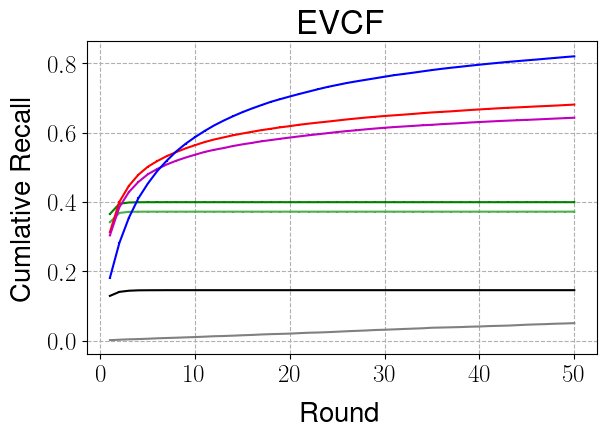

In [71]:
f_do_eval = False
# f_do_eval = True

Nrec= 50
K = 20
Nsampling = 10
BatchSize = 500

RESULT_SAVE_PATH = 'results/{}/{}/multi-clicked-K{}-NRec{}-BatchSize{}'.format(ALGO_NAME,DATASET_NAME, K , Nrec, BatchSize)
# RESULT_SAVE_PATH = 'results/EVCF/{}/multi-clicked-K{}-NRec{}-BatchSize{}'.format(DATASET_NAME, K , Nrec, BatchSize)

if not os.path.exists(RESULT_SAVE_PATH):
    os.makedirs(RESULT_SAVE_PATH)

metrics_dic = {
    "ndcg@{}".format(K):[[] for _ in range(Nrec)],
    # "recall@{}".format(K):[[] for _ in range(Nrec)],
    "precision@{}".format(K):[[] for _ in range(Nrec)],
    "hit_rate@{}".format(K): [[] for _ in range(Nrec)],
    # "prediction_time": [[] for _ in range(Nrec)],
    "cumulative_recall@{}".format(K): [[] for _ in range(Nrec)],
}

methods_dic = {
    "Random":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"random","params":{}},
    "Most Popular":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"most-popular","params":{}},
    "Original":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"original","params":{}},
    "Original(HNSW)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"original-faiss","params":{'beta':1, "faiss_index":index_hnsw}},
    "Stochastic":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"stochastic","params":{}},
    "Stochastic(HNSW)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"stochastic-faiss","params":{"faiss_index":index_hnsw}},
    "Gumbel-Max Trick":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"gumbel","params":{'beta':1}},

}

if f_do_eval:
    results_dic, users_dic = evaluate_multi_rec(model, methods_dic, test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K, batch_size=BatchSize, is_cpu=True)

    with open('{}/results_dic.pkl'.format(RESULT_SAVE_PATH), 'wb') as f:
        pickle.dump(results_dic, f)
    with open('{}/users_dic.pkl'.format(RESULT_SAVE_PATH), 'wb') as f:
        pickle.dump(users_dic, f)
else:
    with open('{}/results_dic.pkl'.format(RESULT_SAVE_PATH), 'rb') as f:
        results_dic = pickle.load(f)
    with open('{}/users_dic.pkl'.format(RESULT_SAVE_PATH), 'rb') as f:
        users_dic = pickle.load(f)
    
n_test_users = np.sum(users_dic['n_batch_users'])

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())


results_all = []
for method_name, method_dic in results_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            metric_list = np.array(metric_list)
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), np.std(np.dot(metric_list, np.diag(1/np.array(users_dic['n_batch_users']))))/np.sqrt(metric_list.shape[0]*metric_list.shape[1])))
        # elif metric_name == "cumulative_recall@{}".format(K):
        #     metric_list = metric_list[-1]
        #     results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        # elif metric_name == "hit_rate@{}".format(K):
        # else:
        #     recall_in_multi_recs_list = np.array(method_dic["metrics"]["cumulative_recall@{}".format(K)]).copy()
        #     first_one_indices = (recall_in_multi_recs_list == 1).argmax(axis=0)
        #     for col in range(recall_in_multi_recs_list.shape[1]):
        #         recall_in_multi_recs_list[(recall_in_multi_recs_list[:, col] == 1) & (np.arange(recall_in_multi_recs_list.shape[0]) != first_one_indices[col]), col] = np.nan
        #     metric_list = np.nanmean(metric_list*recall_in_multi_recs_list, axis=0)
        #     results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list[0]), np.std(metric_list[0])/np.sqrt(len(metric_list[0]))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all.to_csv('{}/metrics.csv'.format(RESULT_SAVE_PATH))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_ylabel("Cumlative Recall", fontsize=20)
ax.set_xlabel("Round", fontsize=20)

colors =  {
    "Random" : "gray",
    "Most Popular" : "black",
    "Original" : "g",
    "Original(HNSW)" : '#4daf4a',
    "Gumbel-Max Trick" : "b",
    # "Gumbel-Max Trick" : "b",
    # "multi-VAE(Gumbel,HNSW)" : "c",
    "Stochastic" : "r",
    "Stochastic(HNSW)" : "m",
}
# colors =  {
#     "Random" : "gray",
#     "Most Popular" : "black",
#     "RecVAE" : "g",
#     "RecVAE(HNSW)" : '#4daf4a',
#     "RecVAE(Gumbel)" : "b",
#     # "Gumbel-Max Trick" : "b",
#     # "multi-VAE(Gumbel,HNSW)" : "c",
#     "RecVAE(Stochastic)" : "r",
#     "RecVAE(Stochastic,HNSW)" : "m",
# }

for method_name, method_dic in results_dic.items():
    cumulative_recalls = method_dic["metrics"]["cumulative_recall@{}".format(K)]
    ax.errorbar(np.arange(1,Nrec+1), np.mean(cumulative_recalls, axis=1), yerr = np.std(cumulative_recalls, axis=1)/np.sqrt(len(cumulative_recalls[0])),
                label=method_name,
                color = colors[method_name],
                # marker = markers[method_name],
               )
    # ax.legend()
ax.set_title(ALGO_NAME, fontsize=24)
ax.xaxis.set_label_coords(0.5,-0.15)
ax.yaxis.set_label_coords(-0.1,0.5)
ax.grid(linestyle="--")
fig.tight_layout()

# fig.legend(loc = 'outside lower center', ncol = 2, bbox_to_anchor=(0.5, -0.2, 0, 0))
fig.savefig("{}/{}-{}-cum_rec-k{}.eps".format(RESULT_SAVE_PATH, ALGO_NAME, DATASET_NAME,K),format="eps", bbox_inches='tight')
fig.savefig("{}/{}-{}-cum_rec-k{}.png".format(RESULT_SAVE_PATH, ALGO_NAME, DATASET_NAME,K),format="png", bbox_inches='tight')
fig.show()

results_all

In [37]:
f_do_eval = False
# f_do_eval = True

plt.rcParams["font.size"] = 18

Nrec= 50
K = 20
Nsampling = 10
BatchSize = 500

# RESULT_SAVE_PATH = 'results/{}/multi-clicked-K{}-NRec{}'.format('ml-20m', K , Nrec)
RESULT_SAVE_PATH = 'results/{}/{}/multi-clicked-K{}-NRec{}-BatchSize{}'.format(ALGO_NAME, DATASET_NAME, K , Nrec, BatchSize)

if not os.path.exists(RESULT_SAVE_PATH):
    os.makedirs(RESULT_SAVE_PATH)

metrics_dic = {
    # "ndcg@{}".format(K):[[] for _ in range(Nrec)],
    # "recall@{}".format(K):[[] for _ in range(Nrec)],
    # "precision@{}".format(K):[[] for _ in range(Nrec)],
    # "hit_rate@{}".format(K): [[] for _ in range(Nrec)],
    "prediction_time": [[] for _ in range(Nrec)],
    # "cumulative_recall@{}".format(K): [[] for _ in range(Nrec)],
}

methods_dic = {
    "Random":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"random","params":{}},
    "Most Popular":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"most-popular","params":{}},
    "Original":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"original","params":{}},
    "Original(HNSW)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"original-faiss","params":{'beta':1, "faiss_index":index_hnsw}},
    "Stochastic":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"stochastic","params":{}},
    "Stochastic(HNSW)":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"stochastic-faiss","params":{"faiss_index":index_hnsw}},
    "Gumbel-Max Trick":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"gumbel","params":{'beta':1}},
}

if f_do_eval:
    results_dic, users_dic = evaluate_multi_rec(model,methods_dic, test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K, batch_size=BatchSize)

    with open('{}/time_results_dic.pkl'.format(RESULT_SAVE_PATH), 'wb') as f:
        pickle.dump(results_dic, f)
    with open('{}/time_users_dic.pkl'.format(RESULT_SAVE_PATH), 'wb') as f:
        pickle.dump(users_dic, f)
else:
    with open('{}/time_results_dic.pkl'.format(RESULT_SAVE_PATH), 'rb') as f:
        results_dic = pickle.load(f)
    with open('{}/time_users_dic.pkl'.format(RESULT_SAVE_PATH), 'rb') as f:
        users_dic = pickle.load(f)
    
n_test_users = np.sum(users_dic['n_batch_users'])

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())


results_all = []
for method_name, method_dic in results_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            metric_list = np.array(metric_list)
            metric_list = np.sum(metric_list, axis=1)
            results.append("{:.3f}({:.3f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        elif metric_name == "cumulative_recall@{}".format(K):
            metric_list = metric_list[-1]
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        # elif metric_name == "hit_rate@{}".format(K):
        # else:
        #     recall_in_multi_recs_list = np.array(method_dic["metrics"]["cumulative_recall@{}".format(K)]).copy()
        #     first_one_indices = (recall_in_multi_recs_list == 1).argmax(axis=0)
        #     for col in range(recall_in_multi_recs_list.shape[1]):
        #         recall_in_multi_recs_list[(recall_in_multi_recs_list[:, col] == 1) & (np.arange(recall_in_multi_recs_list.shape[0]) != first_one_indices[col]), col] = np.nan
        #     metric_list = np.nanmean(metric_list*recall_in_multi_recs_list, axis=0)
        #     results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list[0]), np.std(metric_list[0])/np.sqrt(len(metric_list[0]))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all.to_csv('{}/time_metrics.csv'.format(RESULT_SAVE_PATH))

results_all

All
n_test_users:13667


,prediction_time
Random,1.843(0.007)
Most Popular,0.529(0.001)
Original,6.206(0.004)
Original(HNSW),4.326(0.003)
Stochastic,6.451(0.003)
Stochastic(HNSW),4.537(0.002)
Gumbel-Max Trick,6.799(0.005)


[test]: 100%|██████████| 20/20 [08:39<00:00, 25.98s/it]


['hit_rate@20', 'prediction_time', 'cumulative_recall@20']
All
n_test_users:9782


,hit_rate@20,prediction_time,cumulative_recall@20
Random,0.001230(0.000113),0.000169(0.000000),0.019165(0.000666)
MP,0.024850(0.001282),0.000072(0.000000),0.156251(0.001996)
multi-VAE,0.108610(0.002768),0.000421(0.000000),0.392252(0.002867)
multi-VAE-NSS-HNSW,0.100307(0.002681),0.000231(0.000000),0.364901(0.002878)
multi-VAE-Stochastic,0.158757(0.002703),0.000419(0.000000),0.548021(0.002890)
multi-VAE-Stochastic-NSS-HNSW,0.150958(0.002630),0.000235(0.000000),0.534140(0.002876)
multi-VAE-Gumbel,0.206521(0.002176),0.000618(0.000000),0.701850(0.002561)


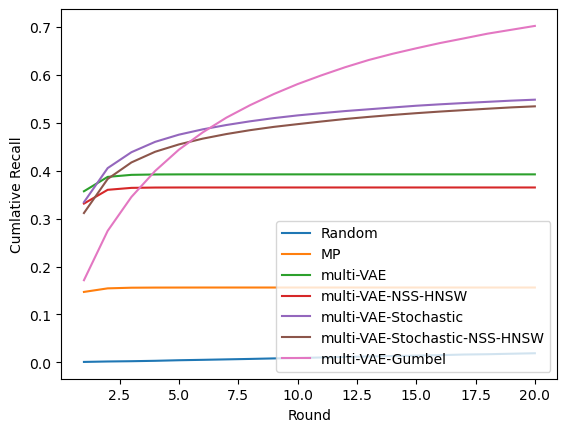

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

Nrec= 20
K = 20
Nsampling = 10

methods_dic, users_dic = evaluate_multi_rec(test_data_tr, test_data_te, n_sampling=Nsampling, n_rec=Nrec, K=K)

n_test_users = users_dic['n_users']

method_names = list(methods_dic.keys())
metric_names = list(methods_dic[method_names[0]]["metrics"].keys())

results_all = []
for method_name, method_dic in methods_dic.items():
    results = []
    for metric_name, metric_list in method_dic["metrics"].items():
        if metric_name == "prediction_time":
            results.append("{:8f}({:8f})".format(np.sum(metric_list)/(n_test_users*Nrec), np.std(np.dot(np.diag(1/user_dic['n_batch_users']), metric_list))/np.sqrt(metric_list.shape[0]*metric_list.shape[1])))
        elif metric_name == "cumulative_recall@{}".format(K):
            metric_list = metric_list[-1]
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        elif metric_name == "hit_rate@{}".format(K):
            recall_in_multi_recs_list = np.array(method_dic["metrics"]["cumulative_recall@{}".format(K)]).copy()
            first_one_indices = (recall_in_multi_recs_list == 1).argmax(axis=0)
            for col in range(recall_in_multi_recs_list.shape[1]):
                recall_in_multi_recs_list[(recall_in_multi_recs_list[:, col] == 1) & (np.arange(recall_in_multi_recs_list.shape[0]) != first_one_indices[col]), col] = np.nan
            metric_list = np.nanmean(metric_list*recall_in_multi_recs_list, axis=0)
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(metric_list.shape[0])))
        else:
            results.append("{:4f}({:4f})".format(np.mean(metric_list), np.std(metric_list)/np.sqrt(len(metric_list))))
    results_all.append(results)
results_all = pd.DataFrame(results_all, columns=metric_names, index=method_names)
print("All")
print("n_test_users:{}".format(n_test_users))
results_all.to_csv('results/run_{}recs_k{}_{}sampling_multiclicked'.format(Nrec, K, Nsampling))


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_ylabel("Cumlative Recall")
ax.set_xlabel("Round")
for method_name, method_dic in methods_dic.items():
    cumulative_recalls = method_dic["metrics"]["cumulative_recall@{}".format(K)]
    ax.plot(np.arange(1,Nrec+1), np.mean(cumulative_recalls, axis=1), label=method_name)
    ax.legend()
fig.show()

# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# ax.set_ylabel("Hit Rate")
# ax.set_xlabel("Round")
# for method_name, method_dic in methods_dic.items():
#     hit_rates = method_dic["metrics"]["hit_rate@{}".format(K)]
#     ax.plot(np.arange(1,Nrec+1), np.mean(hit_rates, axis=1), label=method_name)
#     ax.legend()
# fig.show()

# results_all = pd.read_csv('results/run_{}recs_k{}_{}sampling'.format(Nrec, K, Nsampling))
results_all

In [ ]:
# multi-click recommend-unique-items

In [87]:
def evaluate_multi_rec(data_tr, data_te, n_sampling=1, n_rec=1, K=20):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    
    metrics_dic = {
        # "ndcg@{}".format(K):[[] for _ in range(n_rec)],
        # "recall@{}".format(K):[[] for _ in range(n_rec)],
        # "precision@{}".format(K):[[] for _ in range(n_rec)],
        "hit_rate@{}".format(K): [[] for _ in range(n_rec)],
        "prediction_time": [[] for _ in range(n_rec)],
        "cumulative_recall@{}".format(K): [[] for _ in range(n_rec)],
        # "recall@{}_in_{}recs".format(K,n_rec):[],
    }
    
    methods_dic = {
        "Random":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"Random","params":{}},
        "MP":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"MostPopular","params":{}},
        "multi-VAE":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE","params":{}},
        # "multi-VAE-MAX":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-MAX","params":{}},
        # "multi-VAE-NSS-Comp":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Faiss","params":{"faiss_index":index_flat}},
        "multi-VAE-NSS-HNSW":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Faiss","params":{"faiss_index":index_hnsw}},
        # "multi-VAE-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE","params":{'f_avoid_already_recommended_items': True}},
        # "multi-VAE-Expectation":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation","params":{}},
        # "multi-VAE-Expectation-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation","params":{'f_avoid_already_recommended_items': True}},
        # "multi-VAE-Expectation-Softmax":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation-Softmax","params":{}},
        # "multi-VAE-Expectation-Softmax-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation-Softmax","params":{'f_avoid_already_recommended_items': True}},
        "multi-VAE-Stochastic":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic","params":{}},
        "multi-VAE-Stochastic-NSS-HNSW":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic-Faiss","params":{"faiss_index":index_hnsw}},
        "multi-VAE-Stochastic-MultiSampling":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic-MultiSampling","params":{}},
        # "multi-VAE-Stochastic-wo-same-items":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic","params":{'f_avoid_already_recommended_items': True}},
        "multi-VAE-Gumbel":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel","params":{'beta':1}},
        # "multi-VAE-Gumbel-MultiSampling":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel-MultiSampling","params":{'beta':1}},
        # "multi-VAE-Gumbel-beta0.2":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel","params":{'beta':0.2}},
        # "multi-VAE-Gumbel-beta0.1":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Gumbel","params":{'beta':0.1}},
        # "multi-VAE-Expectation-Gumbel":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Expectation-Gumbel","params":{'beta':0.2}},
        # "multi-VAE-Stochastic-Gumbel":{"metrics":copy.deepcopy(metrics_dic),"alg_name":"multi-VAE-Stochastic-Gumbel","params":{'beta':1}},
    }
    
    users_dic = {
        'n_users':0,
        # 'n_interacts':[],
        'log_vars':[],
               }
    
    with torch.no_grad():
        with tqdm(range(0, e_N, BATCH_SIZE)) as pbar:
        # for start_idx in tqdm(range(0, e_N, BATCH_SIZE)):
            for start_idx in pbar:
                pbar.set_description("[test]")
                  
                # get batch data
                end_idx = min(start_idx + BATCH_SIZE, N)
                data = data_tr[e_idxlist[start_idx:end_idx]]
                heldout_data = data_te[e_idxlist[start_idx:end_idx]]
                
                # avoid users who has no interacts
                u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
                data = data[u_idxlist_wo_any_iteracts]
                heldout_data = heldout_data[u_idxlist_wo_any_iteracts]
                
                # save information about already interected items for each user
                n_already_intaract_items = data.indptr[1:] - data.indptr[:-1]
                max_n_already_intaracted_items = int(cp.max(n_already_intaract_items))
                already_intaracted_idx = cp.squeeze(cp.asarray(data.argmax(axis=1)))
                
                # update experiment information to save
                n_batch_users = data.shape[0]
                users_dic['n_users'] += n_batch_users
                
                op_dic = {
                    'n_sampling':n_sampling,
                    'i_rec':0,
                    'params':{},
                    "pre_topk":torch.Tensor().to(device),
                    "max_n_already_intaracted_items":max_n_already_intaracted_items,
                    # "pre_topk":torch.zeros(n_batch_users, n_items).to(device),
                    'multi_VAE_recon_batch':None, 
                    'multi_VAE_EXP_recon_batch':None,
                    'multi_VAE_EXP_Softmax_recon_batch':None,
                }
                
                for method_name in methods_dic.keys():                    
                    # u_idxlist_wo_any_iteracts = [i for i, x in enumerate(heldout_data.toarray().sum(axis=1)) if x >0]
                    # data = data[u_idxlist_wo_any_iteracts]
                    # heldout_data = heldout_data[u_idxlist_wo_any_iteracts]

                    data_tensor = naive_sparse2tensor(data).to(device)
                    heldout_data_tensor = naive_sparse2tensor(heldout_data).to(device)
                    
                    all_topk_indices = []
                    op_dic["pre_topk"] = torch.Tensor().to(device)
                    op_dic["params"] = methods_dic[method_name]['params']
                    alg_name = methods_dic[method_name]['alg_name']
                    clicked_indices = None
                    
                    for p in range(n_rec):
                        op_dic['i_rec'] = p
                        
                        start = time.perf_counter()
                        topk_indices, recon_batch = my_topk(alg_name, model, data_tensor, K, **op_dic)
                        # recon_batch = my_predict(alg_name, model, data_tensor, **op_dic)
                        # topk = torch.topk(recon_batch, K, dim=1) ## quick sort (to check)
                        t_predict = time.perf_counter() - start
                        
                        # topk_indices = torch.Tensor(topk_indices).to(torch.int64).to(device)
                        op_dic["pre_topk"] = torch.cat([op_dic["pre_topk"],topk_indices], dim=1).to(torch.int64)
                        
                        # methods_dic[method_name]["metrics"]["ndcg@{}".format(K)][p].append(my_evaluate(topk.indices, heldout_data_tensor, "ndcg"))
                        # methods_dic[method_name]["metrics"]["recall@{}".format(K)][p].append(my_evaluate(topk.indices, heldout_data_tensor, "recall"))
                        # methods_dic[method_name]["metrics"]["precision@{}".format(K)][p].append(my_evaluate(topk.indices, heldout_data_tensor, "precision"))
                        methods_dic[method_name]["metrics"]["hit_rate@{}".format(K)][p].append(my_evaluate(topk_indices, heldout_data_tensor, "hit_rate"))
                        
                        # get clicked-item indices and position(for viewed-item indices)
                        
                        binaries = torch.gather(heldout_data_tensor, 1, topk_indices, sparse_grad=True)
                        clicked_indices_tensor = torch.zeros_like(heldout_data_tensor).scatter_(1, topk_indices, binaries)
                        viewed_indices_tensor = torch.zeros_like(heldout_data_tensor).scatter_(1, topk_indices, 1)
                        
                        # calc recall for all predictions
                        all_topk_indices.append(topk_indices)
                        # # all_topk_indices = torch.unique(torch.cat(all_topk_indices, dim=1), dim=1) ## 列数が行によって変化してしまうため、できない
                        all_pred_binary = np.zeros((n_batch_users, n_items), dtype=bool)
                        all_pred_binary[np.arange(n_batch_users)[:, np.newaxis], torch.cat(all_topk_indices, dim=1).cpu().numpy()] = True
                        all_true_binary = (heldout_data > 0).toarray()
                        methods_dic[method_name]["metrics"]["cumulative_recall@{}".format(K)][p].append((np.logical_and(all_true_binary, all_pred_binary).sum(axis=1)).astype(
            np.float32)/ all_true_binary.sum(axis=1))
                        
                        if "prediction_time" in metrics_dic:
                            methods_dic[method_name]["metrics"]["prediction_time"][p].append(t_predict)
                        else:
                            match method_name:
                                case "multi-VAE":
                                    op_dic['multi_VAE_recon_batch'] = recon_batch
                                case "multi-VAE-Expectation":
                                    op_dic['multi_VAE_EXP_recon_batch'] = recon_batch
                                case "multi-VAE-Expectation-Softmax":
                                    op_dic['multi_VAE_EXP_Softmax_recon_batch'] = recon_batch
    
                        # update already-clicked items
                        data_tensor = data_tensor + clicked_indices_tensor
                

    for method_name, method_dic in methods_dic.items():
        for metric_name, metric_list in method_dic["metrics"].items():
                if metric_name == "prediction_time":
                    methods_dic[method_name]["metrics"][metric_name] = np.array(metric_list)
                # elif metric_name == "recall@{}_in_{}recs".format(K,n_rec):
                #     methods_dic[method_name]["metrics"][metric_name] = np.concatenate(metric_list)
                else:
                    for l in range(n_rec):
                        methods_dic[method_name]["metrics"][metric_name][l] = np.array(np.concatenate(metric_list[l]))

[[4 5 0 3]
 [3 0 1 4]
 [5 2 4 0]
 [0 4 2 1]
 [0 1 5 2]]
[[False  True  True  True]
 [ True False  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True False  True]]
[[0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]]
[[5 0 3]
 [3 1 4]
 [5 2 4]
 [0 4 2]
 [0 1 2]]
[array([5, 0, 3]), array([3, 1, 4]), array([5, 2, 4, 0]), array([0, 4, 2, 1]), array([0, 1, 2])]
[array([5, 0, 3]), array([3, 1, 4]), array([5, 2, 4]), array([0, 4, 2]), array([0, 1, 2])]
3
3
3
3
3


[None, None, None, None, None]

In [93]:
A = np.array([[1,2,3],[2,3,4]])
b = np.array([10,100])

np.dot(np.diag(1/b),A)

array([[0.1 , 0.2 , 0.3 ],
       [0.02, 0.03, 0.04]])